In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data

In [3]:
desc = pd.read_csv('/Users/benwolbransky/Sports/MLB/Swish_Takehome/pitches_folder/pitch_by_pitch_metadata.csv',encoding="windows_1258")
desc[desc['column_name'] == 'sz_top']['description'].values

array(['the distance in feet from the ground to the top of the current batterƠs rulebook strike zone as measured from the video by the PITCHf/x operator. The operator sets a line at the batterƠs belt as he settles into the hitting position, and the PITCHf/x software adds four inches up for the top of the zone.'],
      dtype=object)

In [4]:
pitches = pd.read_csv('/Users/benwolbransky/Sports/MLB/Swish_Takehome/pitches_folder/pitches.csv',encoding="windows_1258")

/var/folders/r0/2kjmq69x36j2y2b_5g3jtntc0000gn/T/ipykernel_69428/568705211.py:1: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  pitches = pd.read_csv('/Users/benwolbransky/Sports/MLB/Swish_Takehome/pitches_folder/pitches.csv',encoding="windows_1258")


## High Level EDA

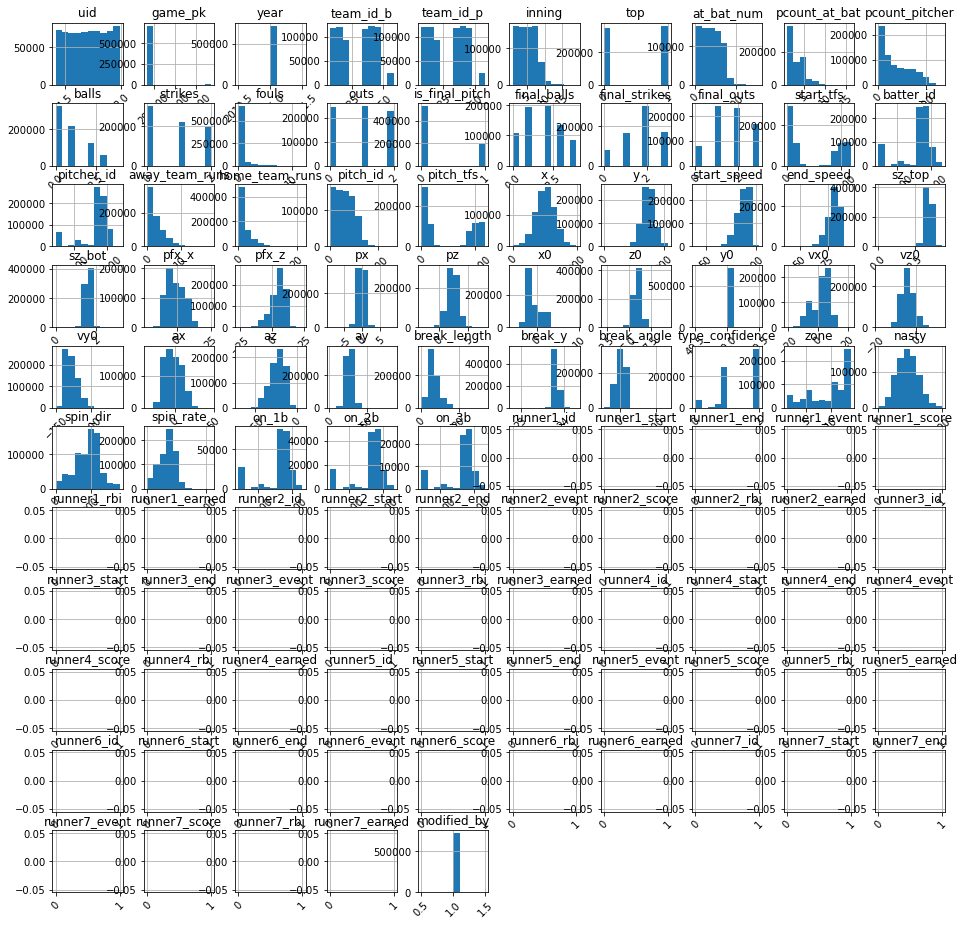

In [5]:
pitches.hist(figsize=(16,16), xrot=45)
plt.show()

In [6]:
## Interesting columns of note; 
# nasty is normally distributed and defined as "a metric attempting to quantify the difficulty of hitting this pitch." 
# pcount pitcher follows a poisson distribution, but probably not noteworthy

## Features to create
# run differential
# I'd like a bool for "runner in scoring position"
# previous pitch speed, trailing pitch speed, and %diff from average in game pitcher velocity
# Lefty vs Lefty etc.
# No ERA or other saber metrics but can probably calculate whiff% and trailing whiff%. rolling average might not be as good as a EWM or something.
# % of previous pitches that are each type. like, 15% slider, 20% fastball etc. Given that each pitcher is different AND I think it would be too complicated to fit a model for each pitcher for a given pitch. 

## Potential next steps
# I'm curious if there's anything to make of the X/Y positional columns -- I'd imagine thats difficult for a pitcher to actually control. Maybe a next step? Could use gaussian mixed modeling to cluster location tendencies.

## Response Variable EDA

<AxesSubplot:>

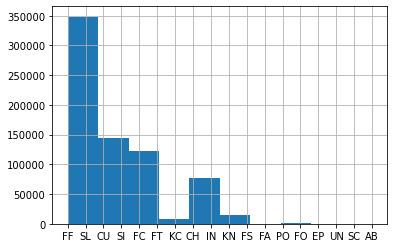

In [7]:
pitches['pitch_type'].dropna().hist()

In [8]:
# Oh wow, that'a a lot more pitch types than I was expecting.

In [9]:
pitches['pitch_type'].dropna().value_counts(normalize=True)

FF    0.332841
SL    0.153145
SI    0.122425
FT    0.113099
CH    0.101358
CU    0.078667
FC    0.058188
FS    0.014655
KC    0.011846
KN    0.006209
IN    0.005662
PO    0.000780
FO    0.000459
FA    0.000285
EP    0.000187
SC    0.000167
UN    0.000024
AB    0.000003
Name: pitch_type, dtype: float64

In [10]:
# I think I'll throw out anything that has a probability of <5% and classify it as "other". That will give us 8 target variables: FF, SL, SI, FT, CH, CU, FC, and Other
# I'll also later on remove all "other" pitch types and see how it affects my test set.

In [11]:
pitches_to_replace = pitches['pitch_type'].dropna().value_counts(normalize=True)
pitches_to_replace = pitches_to_replace.where(pitches_to_replace <= .05).dropna().index.to_list()
pitches_to_replace

['FS', 'KC', 'KN', 'IN', 'PO', 'FO', 'FA', 'EP', 'SC', 'UN', 'AB']

<AxesSubplot:>

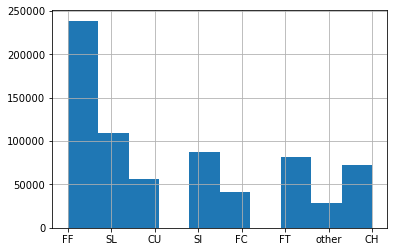

In [12]:
pitches['pitch_type'] = pitches['pitch_type'].replace(pitches_to_replace, "other")
pitches['pitch_type'].dropna().hist()

## Feature Creation EDA

In [13]:
# I want to do more EDA on pitch frequency for previous pitch outcome, previous pitch and run differential. Run differential isn't in data set, so this may have to be a "next step"
# Let's see if there's an effect on the bool RISP.
# Creating some features for additional EDA

### RISP

In [14]:
pitches['RISP'] = pitches[['on_2b','on_3b']].any(axis = 1)

<AxesSubplot:xlabel='pitch_type', ylabel='Proportion'>

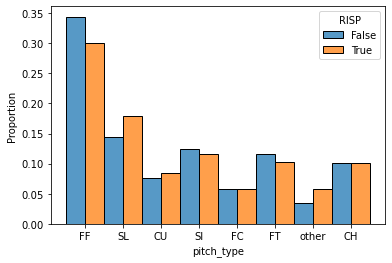

In [15]:
import seaborn as sns
sns.histplot(data=pitches, x='pitch_type', hue='RISP',stat='proportion',common_norm=False,  multiple = 'dodge')

In [16]:
# Nice! Fastballs were about ~5% less frequent when RISP, and Sliders were ~5% more frequent.

### Previous Pitch/Outcome

In [17]:
pitches['previous_pitch'] = pitches.groupby(['game_pk','inning','pitcher_id'])['pitch_type'].shift(1)
pitches['previous_outcome'] = pitches.groupby(['game_pk','inning','pitcher_id'])['type'].shift(1)
# I grouped by game_pk and inning because I don't think it's fair to base the first of an inning based on the last pitch of the last inning

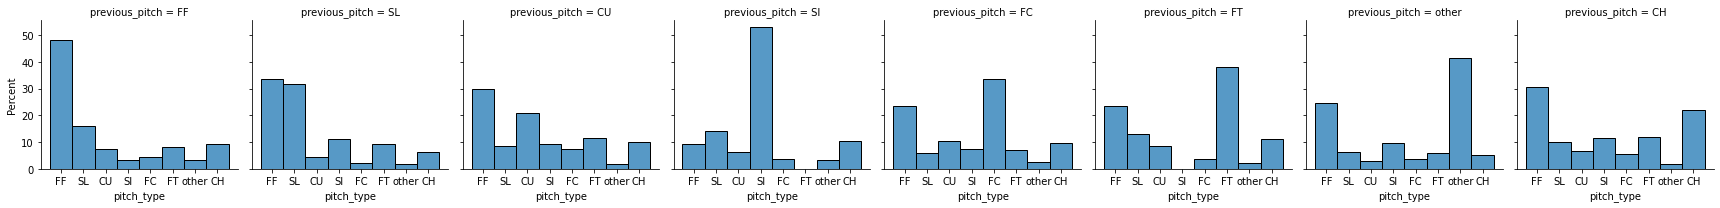

In [18]:
sns.displot(
    pitches, x="pitch_type", col="previous_pitch", common_norm=False,stat='percent',
    height=3, facet_kws=dict(margin_titles=True),
)

In [19]:
## Seems like when a pitcher throws a Slider, 2-seam or Cutter, they follow it up with the same pitch. I'm curious if we can identify WHEN that pitch type is optimal?

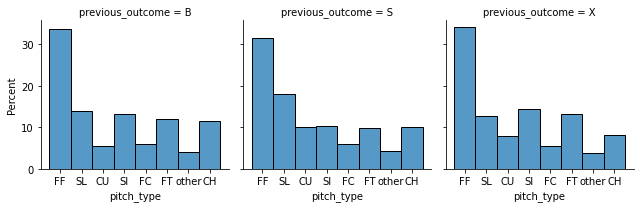

In [20]:
sns.displot(
    pitches, x="pitch_type", col="previous_outcome", common_norm=False,stat='percent',
    height=3, facet_kws=dict(margin_titles=True),
)

In [21]:
# this doesn't seem to matter as much. Maybe it matters depending on the count?

### Count

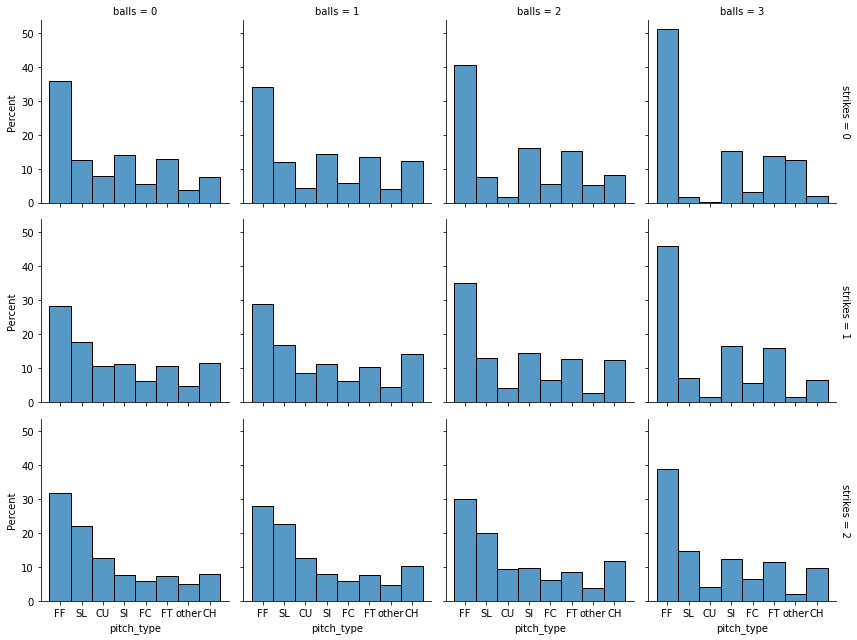

In [22]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="balls", row="strikes", common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

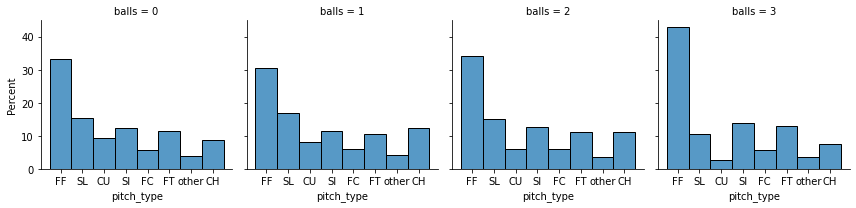

In [23]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="balls", common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

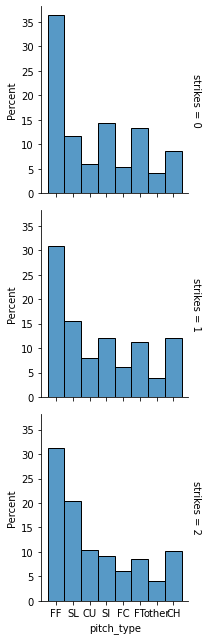

In [24]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", row="strikes", common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

### Outs

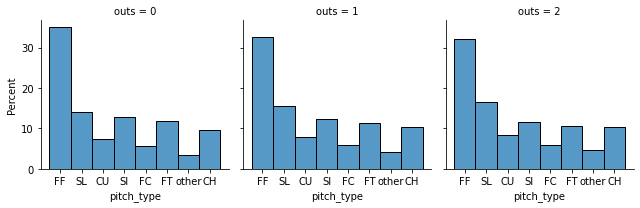

In [25]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="outs", common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

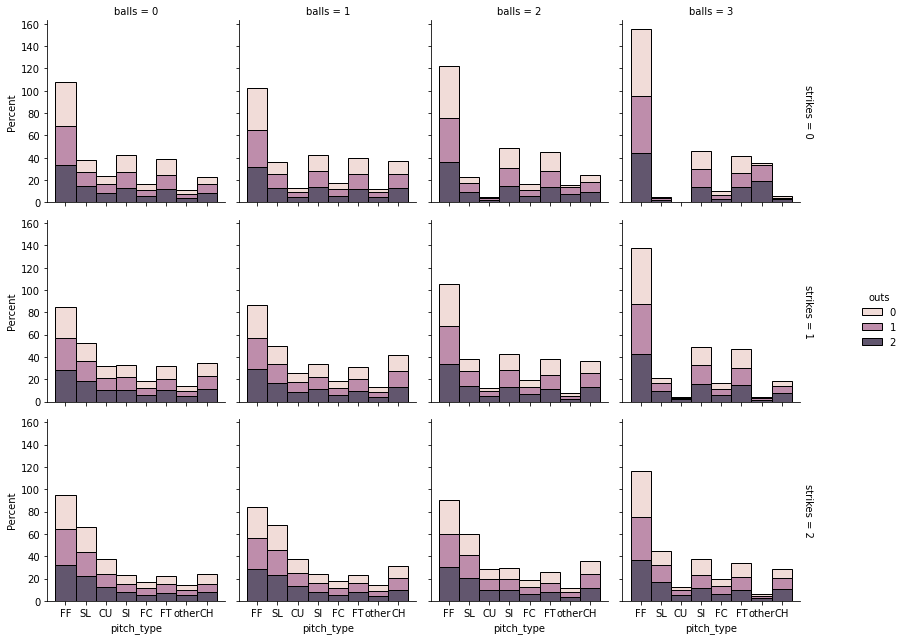

In [26]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="balls", row="strikes",hue='outs',  multiple="stack",common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

In [27]:
# nothing of note, surprisingly

### Handedness

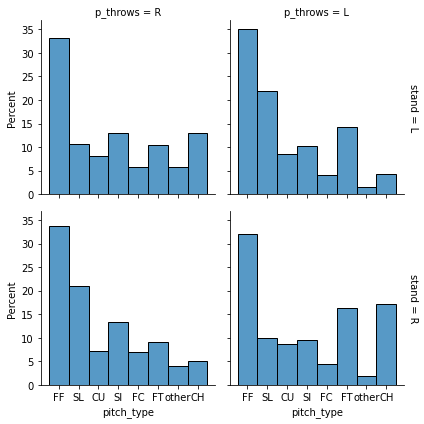

In [28]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="p_throws", row="stand", multiple="stack",common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

In [29]:
## Definitely noteable changes with CH, SL and FT

### Velocity

<AxesSubplot:xlabel='pcount_pitcher', ylabel='start_speed'>

/Users/benwolbransky/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


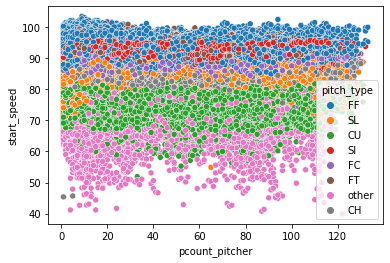

In [30]:
sns.scatterplot(data=pitches.dropna(subset = 'pitch_type'), x="pcount_pitcher", y="start_speed", hue="pitch_type")

In [31]:
# might be messier than i thought. I thought we'd see top velo drop off as pcount went up.

### Run Differential


In [32]:
pitches['run_diff'] = np.where(pitches['top'] == 1, pitches['away_team_runs'] - pitches['home_team_runs'], pitches['home_team_runs'] - pitches['away_team_runs'])
pitches['leading'] = np.where(pitches['run_diff'] > 0, 1,0)
pitches['trailing'] = np.where(pitches['run_diff'] < 0, 1,0)

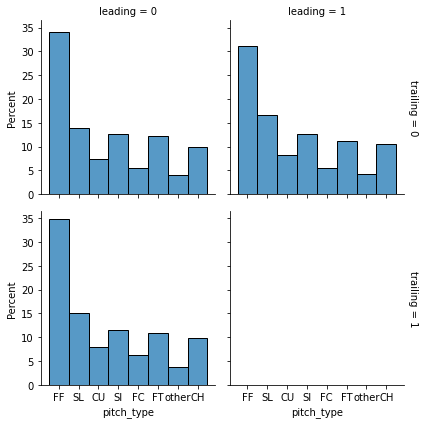

In [33]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="leading", row="trailing", multiple="stack",common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data

In [34]:
# This is really suprising to me. I'm curious how this changes with RISP?

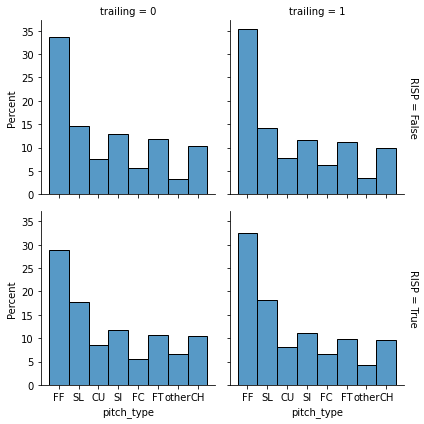

In [35]:
sns.displot(
    pitches.query('balls < 4'), x="pitch_type", col="trailing", row="RISP", multiple="stack",common_norm=False,stat='percent',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

## query to deal with erroneous data